In [1]:
# Initialization
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.misc as spmisc

Populating the interactive namespace from numpy and matplotlib


## Contents
1. [Experiment 1: Grid Layout](#Experiment-1:-Grid-layout)
    1. [Descriptive statistics](#Descriptive-statistics)
    1. [Gini coefficient](#Gini-coefficient)
    1. [Market share](#Market-share)
    1. [Unpredictability](#Unpredictability)
2. [References](#References)

## Experiment 1: Grid layout

In [2]:
# Load data from all worlds in SDW experiment 1
downloads_file = "external/CM/musiclab_data/dynamics_downloads_download_w{world}_v{experiment}.txt"
song_ids = range(1,49)
world_ids = range(1,10)
columns = ['user_id', 'world_id'] \
    + ["dl_{i}".format(i=i) for i in song_ids] \
    + ['timestamp']
df_raw = pd.concat([
    pd.read_csv(
        downloads_file.format(world=w, experiment=1),
        comment="%",
        header=None,
        names=columns
    )
    for w in world_ids])

In [3]:
# Create DataFrame for world/song download counts
# A single count column is much easier to work with
def raw_to_world_song(df_raw):
    col_world_id = []
    col_song_id = []
    col_count = []
    # Get list of world ids present in df_raw
    world_ids = sorted(set(df_raw["world_id"]))
    for cur_world in world_ids:
        # Filter by world
        df_world = df_raw[df_raw["world_id"] == cur_world]
        for cur_song in song_ids:
            col_world_id.append(cur_world)
            col_song_id.append(cur_song)
            count = df_world["dl_{}".format(cur_song)].sum()
            col_count.append(count)
    df_downloads = pd.DataFrame({
        "world_id": col_world_id,
        "song_id": col_song_id,
        "count": col_count
    })
    return df_downloads
df_downloads = raw_to_world_song(df_raw)

### Descriptive statistics

In [4]:
# Count downloads for each song
def count_song_downloads(df_downloads):
    # Create list of song_id values present in input
    song_ids = sorted(set(df_downloads["song_id"]))
    # Create DataFrame for songs
    df_songs = pd.DataFrame({"song_id":song_ids}) \
        .set_index("song_id")
    df_songs["total_counts"] = [
        df_downloads[df_downloads["song_id"] == cur_song]["count"].sum()
        for cur_song in df_songs.index]
    return df_songs

# Count downloads for each world
def count_world_downloads(df_downloads):
    # Create list of world_id values present in input
    world_ids = sorted(set(df_downloads["world_id"]))
    # Create DataFrame for worlds
    df_worlds = pd.DataFrame({"world_id":world_ids}) \
        .set_index("world_id")
    # Count downloads for each world
    df_worlds["total_counts"] = [
        df_downloads[df_downloads["world_id"] == cur_world]["count"].sum()
        for cur_world in df_worlds.index
    ]
    return df_worlds

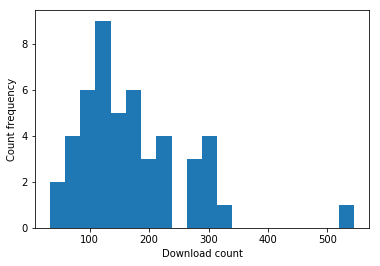

In [5]:
# Plot histogram of download counts
df_songs = count_song_downloads(df_downloads)
df_worlds = count_world_downloads(df_downloads)
plt.hist(df_songs["total_counts"], bins=20)
plt.xlabel("Download count")
plt.ylabel("Count frequency")

### Gini coefficient

In [6]:
def gini(x):
    '''Given a list of counts `x`, return the gini coefficient.'''
    n = len(x)
    gini_num = sum([sum([abs(x_i - x_j) for x_j in x]) for x_i in x])
    gini_den = 2.0 * n * sum([x_i for x_i in x])
    return gini_num / gini_den

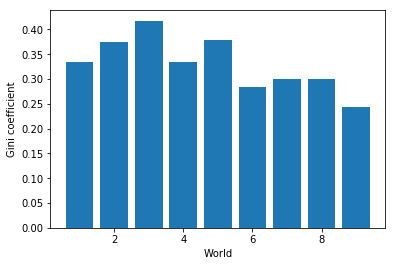

In [7]:
# Calculate and plot the gini coefficient for each world
df_worlds["gini"] = [
    gini(df_downloads[df_downloads["world_id"] == cur_world]["count"])
    for cur_world in df_worlds.index]
plt.bar(df_worlds.index, df_worlds["gini"])
plt.xlabel("World")
plt.ylabel("Gini coefficient")

### Market share

In [8]:
# Calculate market shares
def find_market_share(df_downloads):
    '''Return a DataFrame containing song_id, world_id, and market_share columsn.'''
    # Create a copy of the input to return
    df = df_downloads.copy()
    # Count the total downloads for each world
    df_worlds = count_world_downloads(df)
    # Calculate the market share
    df["market_share"] = [
        float(df.loc[i]["count"]) \
            / float(df_worlds.loc[df.iloc[i]["world_id"]]["total_counts"])
        for i in df.index]
    return df

In [9]:
# Calculate market share for each song/world
df_downloads["market_share"] = find_market_share(df_downloads)["market_share"]

# Copy market share, and convert to rank one world at a time
ranks = []
for cur_world in sorted(set(df_downloads["world_id"])):
    df = df_downloads[df_downloads["world_id"] == cur_world].copy()
    df["market_rank"] = df["market_share"].rank(ascending=False)
    # Store results for this world in an array
    ranks.append(df)
# Concatenate results for all worlds
df_downloads['market_rank'] = pd.concat(ranks)['market_rank']

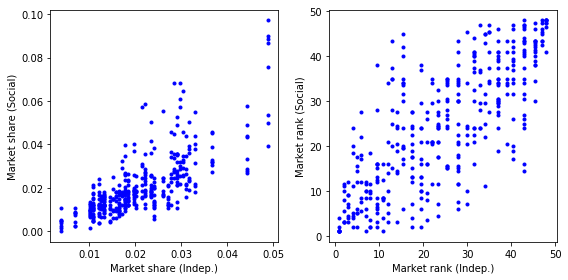

In [10]:
# Create a figure
plt.figure(figsize(8,4))

# Plot social influence vs independent market share
# Create subplots and use first
plt.subplot(1,2,1)
for cur_world in range(1,9):
    plt.plot(
        df_downloads[df_downloads["world_id"] == 9]['market_share'],
        df_downloads[df_downloads["world_id"] == cur_world]['market_share'], '.b')
plt.xlabel("Market share (Indep.)")
plt.ylabel("Market share (Social)")

# Plot social rank vs indpendent rank in second subplot
plt.subplot(1,2,2)
for cur_world in range(1,9):
    plt.plot(
        df_downloads[df_downloads["world_id"] == 9]['market_rank'],
        df_downloads[df_downloads["world_id"] == cur_world]['market_rank'], '.b')
plt.xlabel("Market rank (Indep.)")
plt.ylabel("Market rank (Social)")
plt.tight_layout()


## Unpredictability

In [11]:
def find_unpredictability(df_downloads):
    '''Return a DataFrame indexed by song_id with an `unpredictability` column.'''
    # Create the DataFrame and index from the provided download data
    df = pd.DataFrame({"song_id": list(set(df_downloads["song_id"]))}) \
        .set_index("song_id")
    # Get market share of each song in each world
    df_market = find_market_share(df_downloads)
    # Calculate and return the unpredictability based on equation in SDW2006
    df["unpredictability"] = [
        sum([
            sum([
                abs(
                    df_market[
                        (df_market["song_id"] == cur_song)
                        & (df_market["world_id"] == world_j)
                    ]["market_share"].sum()
                    - df_market[
                        (df_market["song_id"] == cur_song)
                        & (df_market["world_id"] == world_k)
                    ]["market_share"].sum()
                ) / spmisc.comb(len(df_worlds), 2)
                for k, world_k in enumerate(df_worlds.index[j+1:])])
            for j, world_j in enumerate(df_worlds.index)])
        for cur_song in df.index]
    return df

In [12]:
# Calculate unpredictability in social influence worlds
df_social = df_downloads[df_downloads["world_id"] != 9]
df_songs["unpredictability"] = find_unpredictability(df_social)["unpredictability"]

# Calculate unpredictability in independent world
# First, copy data for only independent world
df_indep = df_raw[df_raw["world_id"] == 9].copy()
# Repeatedly split users into two random worlds and calculate uncertainties
unpredictability = []
num_iter = 50
for i in range(num_iter):
    df_indep["world_id"] = np.random.randint(0, 2, size=len(df_indep))
    df_indep_dl = raw_to_world_song(df_indep)
    u_i = find_unpredictability(df_indep_dl)["unpredictability"]
    unpredictability.append(u_i) 
# Average results
# Elements are pandas Series objects, which can be added to each other
u = np.sum(unpredictability, axis=0) / float(num_iter)
# Add to the song DataFrame
df_songs["unpredictability_indep"] = u

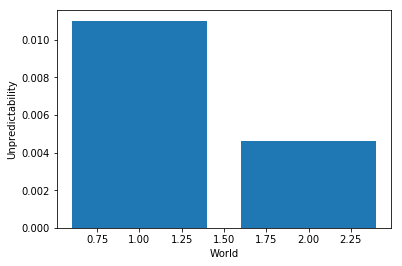

In [13]:
# Plot the unpredictability for social and independent worlds
u_social = df_songs["unpredictability"].sum() / float(len(df_songs))
u_indep = df_songs["unpredictability_indep"].sum() / float(len(df_songs))
plt.figure(figsize=(6,4))
plt.bar([1, 2], [u_social, u_indep])
plt.xlabel("World")
plt.ylabel("Unpredictability")


## References

1. Salganik, M. J., Dodds, P. S., & Watts, D. J. (2006). Experimental study of inequality and unpredictability in an artificial cultural market. _Science_, 311(5762), 854-856.